![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/extras/practica_tfrecord.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica Extra No. 1**

## **Escritura de Archivos con TFRecord**

## **Objetivos**
- Aprender a usar la API de Tensorflow para la escritura y la lectura de archivos
- Utilizar TFRecord como método de almacenamiento eficiente para entrenamientos

In [ ]:
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [ ]:
import numpy as np
import pandas as pd

import os
from glob import glob
from scipy.io import loadmat

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from utils import general as gen
import cv2

import re

from typing import Optional, Union, List, Tuple, ByteString

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import files

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
caltech_data = "1hbzc_P1FuxMkcabkgn9ZKinBwW683j45"

In [ ]:
downloaded = drive.CreateFile({"id": caltech_data})
downloaded.GetContentFile("CUB_200_2011.tgz")

In [ ]:
!tar -xzf CUB_200_2011.tgz
!rm CUB_200_2011.tgz

## **Lectura y Preparación**
- En esta ocasión vamos a utilizar un formato de archivo especial para trabajar con Tensorflow que nos va a ayudar a leer y escribir de forma eficiente varios archivos de cualquier formato.
- Es la forma como Tensorflow almacena archivos de forma binaria.
> https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564
> https://www.tensorflow.org/tutorials/load_data/tfrecord

In [ ]:
filenames = glob("CUB_200_2011/images/*/*.jpg")

In [ ]:
len(filenames)

11788

In [ ]:
filenames

In [ ]:
classnames = []

with open("CUB_200_2011/classes.txt", "r") as f:
    classnames = f.readlines()

classnames = list(map(
    lambda x: x.replace("\n", "").split(" ")[1], 
    classnames
))

class_dict = {
    classnames[i]: i for i in list(range(len(classnames)))
}

In [ ]:
class_dict.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [ ]:
distributions = {
    class_name: len(glob(f"CUB_200_2011/images/{class_name}/*.jpg")) 
    for class_name in classnames
}

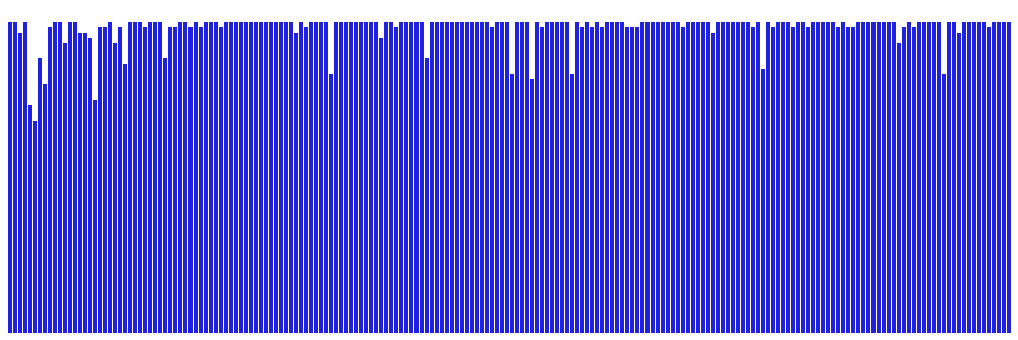

In [ ]:
plt.figure(figsize=(18, 6))
sns.barplot(
    x=list(distributions.keys()), 
    y=list(distributions.values()), 
    color="b"
)
plt.axis("off")
plt.show()

In [ ]:
image_list = []
bbox_list = []

pattern = r"([1-9]|[0-9]{2,3}|[0-9]{4,5})( )"

with open("CUB_200_2011/images.txt", "r") as f:
    image_list = f.readlines()

with open("CUB_200_2011/bounding_boxes.txt", "r") as f:
    bbox_list = f.readlines()

image_list = list(map(
    lambda x: 'CUB_200_2011/images/{}'.format(
        x.replace("\n", "").split(" ")[1]
    ), 
    image_list
))

bbox_list = list(map(
    lambda x: re.sub(
        pattern, "", 
        x.replace("\n", "")
    ),
    bbox_list
))

labels = [class_dict[x.split("/")[-2]] for x in image_list]

file_class = np.array(list(zip(image_list, bbox_list, labels)))

In [ ]:
full_train, test = train_test_split(
    file_class, test_size=0.2, 
    random_state=1234, stratify=file_class[:, -1]
)

train, val = train_test_split(
    full_train, test_size=0.2,
    random_state=1234, stratify=full_train[:, -1]
)

In [ ]:
len(train), len(val), len(test)

(7544, 1886, 2358)

In [ ]:
train

array([['CUB_200_2011/images/087.Mallard/Mallard_0071_76940.jpg',
        '247.0 68.0 190.0 219.0', '86'],
       ['CUB_200_2011/images/093.Clark_Nutcracker/Clark_Nutcracker_0005_85190.jpg',
        '95.0 49.0 356.0 319.0', '92'],
       ['CUB_200_2011/images/133.White_throated_Sparrow/White_Throated_Sparrow_0073_129110.jpg',
        '51.0 66.0 356.0 223.0', '132'],
       ...,
       ['CUB_200_2011/images/188.Pileated_Woodpecker/Pileated_Woodpecker_0059_180177.jpg',
        '105.0 81.0 288.0 418.0', '187'],
       ['CUB_200_2011/images/030.Fish_Crow/Fish_Crow_0059_25864.jpg',
        '179.0 75.0 125.0 199.0', '29'],
       ['CUB_200_2011/images/079.Belted_Kingfisher/Belted_Kingfisher_0056_70516.jpg',
        '101.0 173.0 147.0 292.0', '78']], dtype='<U101')

In [ ]:
def process_image(
    img_file: Optional[str],
) -> Optional[ByteString]:
    """
    Function to process image to byte buffer
    :param img_file: The file to be buffered
    :param type: Optional[str]
    :return: The image buffered
    :rtype: Optional[ByteString]
    """
    with open(img_file, "rb") as f:
        image_buffer = f.read()
    return image_buffer

def int64_feature(
    value: Union[List[int], int]
) -> tf.train.Feature:
    """
    Function to transform integer
    to Tensorflow Feature list
    :param value: The value to be transformed
    :param type: Union[List[int], int]
    :return: The value transformed to TF Feature
    :rtype: tf.train.Feature
    """
    if not isinstance(value, list):
        value = [value]

    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value: ByteString) -> tf.train.Feature:
    """
    Function to transform a byte 
    string to a Tensorflow Feature list
    :param value: The byte string to be transformed
    :param type: ByteString
    :return: The value transformed to TF Feature
    :rtype: tf.train.Feature
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to_example(
    image_buffer: ByteString, 
    label: int, 
    bbox: List[int]
) -> tf.train.Example:
    """
    Function to tansform the image buffer, the 
    label and the bounding box to an Example, 
    which is going to be serialized in 
    the TFRecord file
    :param image_buffer: The image buffer string
    :param type: ByteString
    :param label: The label of the image
    :param type: int
    :param bbox: The array of coordinates 
    of the location of the class bird
    :param type: List[int]
    :return: The TF Example object ready to be 
    Serialized in the TFRecord File
    :rtype: tf.train.Example
    """
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": bytes_feature(tf.compat.as_bytes(image_buffer)),
                "class": int64_feature(label),
                "bbox": int64_feature(bbox)
            }
        )
    )
    return example

def create_tfrecord(
    file_collection: Optional[List[str]], 
    tfrecord_name: str = "collection.tfrec"
):
    """
    Function to serialize into TFRecord file 
    all the Tensorflow examples created in the file collection
    :param file_collection: The collection of images, 
    labels and bboxes to be stored
    :param type: Optional[List[str]]
    :param tfrecord_name: The name of the TFRecord 
    file to be created
    :para type: str
    """
    with tf.io.TFRecordWriter(tfrecord_name) as writer:
        for image_filepath, bbox, label in tqdm(file_collection):
            bbox = [
                int(float(bbox_coord)) 
                for bbox_coord in bbox.split(" ")
            ]
            label = int(label)
            image_buffer = process_image(image_filepath)
            example = convert_to_example(image_buffer, label, bbox)
            writer.write(example.SerializeToString())

In [ ]:
create_tfrecord(train, "train.tfrec")

  0%|          | 0/7544 [00:00<?, ?it/s]

In [ ]:
create_tfrecord(val, "val.tfrec")

  0%|          | 0/1886 [00:00<?, ?it/s]

In [ ]:
create_tfrecord(test, "test.tfrec")

  0%|          | 0/2358 [00:00<?, ?it/s]

## **Carga y Visualización**

In [ ]:
@tf.function
def parse_image_function(
    example_input: Optional[tf.Tensor],
) -> Optional[Tuple[tf.Tensor]]:
    """
    TF Function to parse a TFRecord 
    serialized single example
    :param example_input: The serialized TF 
    Example to be parsed
    :param type: Optional[tf.Tensor]
    :return: The resulting image, label 
    and bbox of the parsed Example
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    # We extract the feature description from the example
    # represented by features of fixed length and fixed type
    image_feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
        "bbox": tf.io.FixedLenFeature([4], tf.int64),
    }

    # We parse example by example
    feature = tf.io.parse_single_example(
        example_input, image_feature_description,
    )

    # We get the features from the feature dict
    image = feature["image"]
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32) / 255.

    label = tf.cast(feature["class"], tf.int32)
    bbox = tf.cast(feature["bbox"], tf.float32)

    return image, label, bbox

@tf.function
def process_image(
    image: Optional[tf.Tensor], 
    label: Optional[tf.Tensor], 
    bbox: Optional[tf.Tensor],
) -> Optional[Tuple[tf.Tensor]]:
    """
    Function to process the image, label and bbox
    :param image: The image to be processed
    :param type: Optional[tf.Tensor]
    :param label: The label of the image
    :param type: Optional[tf.Tensor]
    :param bbox: The bbox of the image
    :param type: Optional[tf.Tensor]
    :return: The image, label and bbox processed
    :rtype: Optional[Tuple[tf.Tensor]]
    """
    shape = tf.shape(image)

    image = tf.image.resize(image, (224, 224))

    x_scale = 224. / tf.cast(shape[1], tf.float32)
    y_scale = 224. / tf.cast(shape[0], tf.float32)

    bbox = [
        tf.round(bbox[0] * x_scale),
        tf.round(bbox[1] * y_scale),
        tf.round(bbox[2] * x_scale),
        tf.round(bbox[3] * y_scale),
    ]

    return image, label, bbox

In [ ]:
ds = tf.data.TFRecordDataset("test.tfrec")

In [ ]:
ds = ds.map(parse_image_function)
ds = ds.map(process_image)

In [ ]:
for img, label, bbox in ds.take(4):
    tf.print(img.shape)
    tf.print(label)
    tf.print(bbox)

TensorShape([224, 224, 3])
105
[64 59 128 93]
TensorShape([224, 224, 3])
121
[59 57 141 129]
TensorShape([224, 224, 3])
199
[33 22 105 167]
TensorShape([224, 224, 3])
16
[51 36 132 188]


In [ ]:
imgs = []

for img, label, bbox in ds.take(4):
    new_img = cv2.rectangle(
        img.numpy(), 
        (bbox[0], bbox[1]), 
        (bbox[0] + bbox[2], bbox[1] + bbox[3]), 
        (1, 0, 0), 3
    )
    imgs.append(new_img)

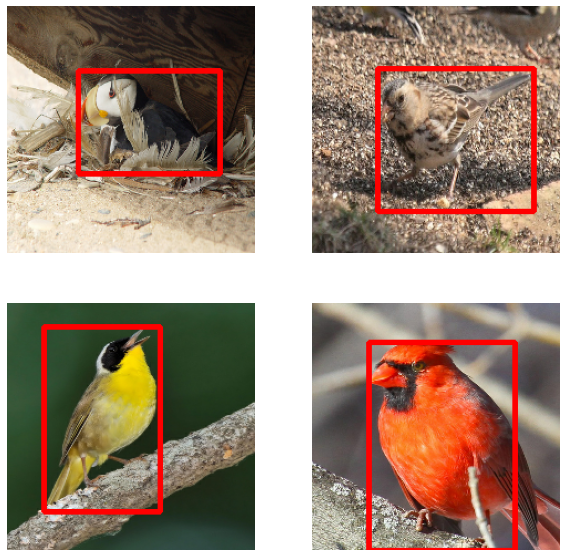

In [ ]:
gen.visualize_subplot(
    imgs, [""] * len(imgs),
    (2, 2), (10, 10),
)

In [ ]:
files.download("train.tfrec")
files.download("val.tfrec")
files.download("test.tfrec")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>